# Word embeddings with Word2Vec

Frequency as well as dictionary based approaches from the previous chapters ignore semantic relationships between the words in the document. Just recording word frequencies will not allow us to understand the context of textual information. In addition, we also mentioned that these models may also be negatively impacted by numerical issues arising from high dimensionality and sparsity of word vectors.

Due to these limitations we are going to take a look at statistical language models which aim to learn embeddings for words and documents that capture semantic meaning. An embedding is a collection of numerical values that represent a word or document, i.e., usually a real-valued vector. The useful characteristic of these models is that words or documents with similar semantic meaning will have a similar numerical representation. If you hear about this concept for the first time, you may wonder why one should represent words by vectors and how it makes sense that words with similar meaning have similar vectors. Thus, let us take a look at a meaningful example. The scatter plot below visualizes different dog breeds w.r.t. their weight and size. Assuming, we only use these two metrics to characterize different dog breeds, the breed "Airedale Terrier" is represented by the vector 

$$
\boldsymbol{x}^{(\text{Airedale})} = 
\begin{pmatrix}
22.5 \\
58.5 \\
\end{pmatrix}
$$

so this is how you may picture how a word is transformed into a vector. Furthermore, if you scroll over the points in the scatter plot, you may observe that breeds with similar characteristics have similar vectors (vectors that are close to each other), so this is how you may picture how words with similar meaning may have similar vectors. Furhtermore, by transforming dog breeds into vectors, we could use vector calculus to derive new insights. For instance, we can calculate the average vector of certain dog breeds to determine a representative embedding for this group of breeds. 

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

# https://tarigs.com/size-table-dog/
dog_breeds_2d = pd.read_csv("../data/dog_breeds.csv")
dog_breeds_2d.set_index("breed", inplace = True, drop = True)
dog_breeds_2d.dropna(inplace = True)
dog_breeds_2d.head()

,weight,size
breed,,
Afghan hound,25.0,68.5
Airedale Terrier,22.5,58.5
American Staffordshire Terrier,16.0,45.5
Australian Shepherd,24.0,52.0
Borzoi,36.0,76.5


In [2]:
# hover over each point to examine the dog breed
fig = px.scatter(dog_breeds_2d, x = "weight", y = "size", hover_name = dog_breeds_2d.index, width = 800, height = 600, title = "Dog breed vectorization")
fig.show()

In [3]:
from sklearn.metrics.pairwise import euclidean_distances

# determine all pairwise euclidean distances
pairwise_distances = pd.DataFrame(euclidean_distances(dog_breeds_2d), index = dog_breeds_2d.index, columns = dog_breeds_2d.index)
pairwise_distances.iloc[:5, :5]

breed,Afghan hound,Airedale Terrier,American Staffordshire Terrier,Australian Shepherd,Borzoi
breed,,,,,
Afghan hound,0.000000,10.307764,24.698178,16.530275,13.601471
Airedale Terrier,10.307764,0.000000,14.534442,6.670832,22.500000
American Staffordshire Terrier,24.698178,14.534442,0.000000,10.307764,36.891733
Australian Shepherd,16.530275,6.670832,10.307764,0.000000,27.280946
Borzoi,13.601471,22.500000,36.891733,27.280946,0.000000


In [4]:
# for instance, which is the most similar breed to the American Staffordshire Terrier if we identify it the closest euclidean distance
breed_name = "American Staffordshire Terrier"
pairwise_distances.columns[np.argsort(pairwise_distances.loc[breed_name].values)[1]]

'Standard Schnauzers'

In [5]:
# we can determine the average of two breed vectors and look for the most similar dog breed to this vector
bullterier_vector = (dog_breeds_2d.loc["Staffordshire Bullterrier"] + dog_breeds_2d.loc["Bull terrier"]).divide(2)
pairwise_distances.columns[np.argsort(euclidean_distances(bullterier_vector.values.reshape(1, -1), dog_breeds_2d.values))[0][0]]

'American Staffordshire Terrier'

This example is only meant to give you an idea that vector representations of words may not be as abstract is it may sound in the first place. However, if we want to extend this idea to a more general scenario, we are going to make use of other numbers than attributes of the word. In our example this has been the size and the weight of a dog breed, obviously, not every word is associated with object that have meaningful size and weight characteristics, e.g., the word elegant. Furthermore, we may need more than just two numbers to capture semantic meaning. 

## Word2Vec

A popular model which is build upon a neural network architecture is called Word2Vec and has been presented by [Mikolov et al. (2013)](https://arxiv.org/abs/1301.3781) and [Mikolov et al. (2013)](https://arxiv.org/abs/1310.4546). The model represents every word by a $p$-dimensional vector. In comparison to our example, each real-valued number in a word vector does not have a specific meaning. However, after the model is trained, the vectors will be similar to each other if the words have similar meaning. Two versions of the Word2Vec model exist: (1) the continuous bag of words approach (CBOW), and, (2) the skip-gram (SG) model. For both approaches, we take a look at the context around a center word. Let us denote $w_j$ as the center word. Context is defined by the window size whose length $2 \cdot t$ needs to be chosen by the user. The context words are $t$ words to the left and $t$ words to the right of the context word: $w_{j-t}, w_{j-t+1}, ..., w_{j-1}, w_{j+1}, w_{j + t -1}, w_{j + t}$. For instance, given the sentence, "the dog would like a piece of the sandwich", setting the center word "like" and a window size of $4$, the context words are: "dog, would, a, piece". The CBOW model tries to predict the center word by the context words, the SG model tries to predict context words, given the center word. 

The easiest way to understand the model is to take a look at a minimal example. So, let's go: First, everything starts with a corpus. Ours consists of three sentences:


In [6]:
from gensim.utils import simple_preprocess

raw_corpus = [
    "The dog would like a piece of the sandwich",
    "I like to eat ice-cream",
    "A dog is a good friend"
]

corpus = [simple_preprocess(doc, min_len = 1) for doc in raw_corpus]
corpus

[['the', 'dog', 'would', 'like', 'a', 'piece', 'of', 'the', 'sandwich'],
 ['i', 'like', 'to', 'eat', 'ice', 'cream'],
 ['a', 'dog', 'is', 'a', 'good', 'friend']]

Next, we build a vocabulary in which each word is mapped to an index.

In [7]:
word2index = dict()
idx = 0
for doc in corpus:
    for word in doc:
        if word in word2index.keys():
            continue
        else:
            word2index[word] = idx
            idx += 1

word2index

{'the': 0,
 'dog': 1,
 'would': 2,
 'like': 3,
 'a': 4,
 'piece': 5,
 'of': 6,
 'sandwich': 7,
 'i': 8,
 'to': 9,
 'eat': 10,
 'ice': 11,
 'cream': 12,
 'is': 13,
 'good': 14,
 'friend': 15}

### CBOW

The CBOW model is build upon a multi-class classification task. One predicts the probabilities for the center word, given the context: $P \left( w_i | w_{i-t}, w_{i-t+1}, ..., w_{i-1}, w_{i+1}, w_{i + t -1}, w_{i + t} \right) $. Let us denote $\boldsymbol{x}_{j}$ as the one-hot encoded vector for word $j$ where $j$ is the number of the index in the dictionary. The number of categories is equal to the number of words, e.g., $d = 16$. To generate probability predictions, we make use of two matrices $\boldsymbol{W}, \boldsymbol{V}$ whose elements are parameters which need to be trained. We start with a sequence of context words and their one-hot encoded vectors, e.g., "the", "would" is represented by $\boldsymbol{x}_{0}, \boldsymbol{x}_{2}$ which can be subsumed in a matrix:

$$\boldsymbol{C}^{(0, 2)} = \begin{pmatrix} \boldsymbol{x}_{0} \\ \boldsymbol{x}_{2} \end{pmatrix}$$

See in the cell below how this looks like for our example:

In [8]:
from torch.nn.functional import one_hot
import torch

# define the number of terms in the lexicon
d = len(word2index.keys())

C_02 = one_hot(torch.LongTensor([0, 2]), num_classes=d)
C_02

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Next, we multiply this matrix with the context word embedding matrix $\boldsymbol{W}$, its first dimension must be equal to $d$, its second dimension $p$ can be set by the user and will define the dimension of word embeddings. Let us set $p=3$ for our example and take a look at an example below whose parameters have been randomly initialized.

In [9]:
# embedding dimension
p = 3

W = torch.nn.Embedding(num_embeddings=d, embedding_dim=p)
W.weight

Parameter containing:
tensor([[ 0.3976,  1.8370, -0.7467],
        [-0.2357,  0.1192, -1.4524],
        [-0.4676, -0.1528, -0.1549],
        [-0.0523,  0.3392,  0.1652],
        [-0.1388,  0.4070,  1.5852],
        [ 1.1340,  1.1303, -0.1362],
        [-0.7280, -0.1015, -0.4547],
        [ 0.7729,  0.2718, -1.0115],
        [ 0.2859,  0.2294, -0.6681],
        [ 0.2799, -0.7635,  0.8796],
        [ 0.9279,  0.7366, -0.7126],
        [-1.4260,  0.2416,  0.2993],
        [-0.7399,  0.4237,  0.6338],
        [-1.0680, -1.1065, -1.2660],
        [ 1.4752,  0.4261, -0.2605],
        [ 0.3493, -1.1180, -0.2333]], requires_grad=True)

This can be seen as the weights from the first layer in a neural network whose input are the one-hot context word vectors with dimension $2t \times d$. Each row of this matrix relates to the word embedding for one word if it is used in the context of a center word. Multiplying the one-hot vector input with this matrix basically transforms the one-hot encoded input into numerical representations of the context words. Let us continue the example below:

In [10]:
c = W(torch.LongTensor([0, 2]))
c

tensor([[ 0.3976,  1.8370, -0.7467],
        [-0.4676, -0.1528, -0.1549]], grad_fn=<EmbeddingBackward0>)

Note that we observe row vectors with index numbers $0,2$ because these are the index numbers for our example "the", "would". In order to condense the information of the context words into one vector, one can average or sum these vectors row-wise. Let us build the average and continue with this vector that we denote as the context vector $\boldsymbol{c}$.

In [11]:
c = c.mean(axis = 0)
c

tensor([-0.0350,  0.8421, -0.4508], grad_fn=<MeanBackward1>)

To determine the probabilities for the center words, we multiply this vector with the matrix $\boldsymbol{V}$ which must have dimensionality $p \times d$ and ...

In [12]:
V = torch.nn.Linear(in_features=p, out_features=d, bias = False)
z = V(c)
z

tensor([ 0.2101, -0.5024,  0.3354,  0.0228,  0.1365, -0.0040, -0.0462, -0.0395,
         0.2993, -0.1681,  0.3779, -0.2352,  0.4813,  0.1923,  0.2424,  0.1358],
       grad_fn=<SqueezeBackward4>)

...use the softmax function.

In [13]:
prob_w = torch.nn.functional.softmax(z, dim = 0)
prob_w

tensor([0.0685, 0.0336, 0.0776, 0.0568, 0.0636, 0.0553, 0.0530, 0.0534, 0.0749,
        0.0469, 0.0810, 0.0439, 0.0898, 0.0673, 0.0707, 0.0636],
       grad_fn=<SoftmaxBackward0>)

In our example, the true category would be the word "dog" which is represented by the one-hot encoded vector $\boldsymbol{w}_1$ with index $1$. Thus, in order to determine the value of the crossentropy loss function, we calculate the dot product and determine the negative log of this value. 

In [14]:
-np.log((prob_w @ one_hot(torch.LongTensor([1]), num_classes=d).reshape(d, 1).float()).detach().numpy())

array([3.393486], dtype=float32)

Let us go through these steps formally:

1. Generate a one-hot encoded context input, given a context length $2t$, $\boldsymbol{C} \in [0, 1]^{2t \times d}$
2. Multiply this with the context word vector matrix, $\boldsymbol{W} \in \mathbb{R}^{d \times p}$ and aggregate the outcome to a single vector with dimension $p$
3. Multiply this vector with the center word vector matrix $\boldsymbol{V} \in \mathbb{R}^{p \times d}$ and transform the output with the softmax function to probabilities
4. Multiply the probability prediction with the one-hot vector of the center word to determine the loss

This is done for all possible center word context word combinations and gradient descent can be used to update the parameters of $\boldsymbol{W}$ and $\boldsymbol{V}$. After training is finished one usually uses the columns of $\boldsymbol{V}$ as word embeddings where word with index $0$ is represented by the first column, word with index $1$ is represented by the second column and so on. Let us take a look how we could do this by hand using tensorflow for our example.

First we generate the samples. Note that sample indices are used to derive the one-hot information for the center words. 

In [15]:
# context length
k = 2
context_indices = [j for j in range(-k, k+1) if j != 0]

# generate training samples
sample_words = []
samples = []
for doc in corpus:
    for i in range(k, len(doc) - k):
        center_word = doc[i]
        center_word_idx = word2index[doc[i]]
        context_words = [doc[i + idx] for idx in context_indices]
        context_word_idx = [word2index[doc[i + idx]] for idx in context_indices]
        sample_words.append((context_words, center_word))
        samples.append((context_word_idx, center_word_idx))

print("This is how the training samples look like:")
print(sample_words)
print("")
print("This is how the training samples information is provided:")
print(samples)

This is how the training samples look like:
[(['the', 'dog', 'like', 'a'], 'would'), (['dog', 'would', 'a', 'piece'], 'like'), (['would', 'like', 'piece', 'of'], 'a'), (['like', 'a', 'of', 'the'], 'piece'), (['a', 'piece', 'the', 'sandwich'], 'of'), (['i', 'like', 'eat', 'ice'], 'to'), (['like', 'to', 'ice', 'cream'], 'eat'), (['a', 'dog', 'a', 'good'], 'is'), (['dog', 'is', 'good', 'friend'], 'a')]

This is how the training samples information is provided:
[([0, 1, 3, 4], 2), ([1, 2, 4, 5], 3), ([2, 3, 5, 6], 4), ([3, 4, 6, 0], 5), ([4, 5, 0, 7], 6), ([8, 3, 10, 11], 9), ([3, 9, 11, 12], 10), ([4, 1, 4, 14], 13), ([1, 13, 14, 15], 4)]


Next, we prepare these training samples such they can be inserted into a neural network.

In [16]:
# prepare training examples for a neural network
X = [sample[0] for sample in samples]
y = [sample[1] for sample in samples]

print("Input word index labels for the neural network:")
print(X)
print("")
print("Target word labels for the neural network:")
print(y)

Input word index labels for the neural network:
[[0, 1, 3, 4], [1, 2, 4, 5], [2, 3, 5, 6], [3, 4, 6, 0], [4, 5, 0, 7], [8, 3, 10, 11], [3, 9, 11, 12], [4, 1, 4, 14], [1, 13, 14, 15]]

Target word labels for the neural network:
[2, 3, 4, 5, 6, 9, 10, 13, 4]


Below you see how we could train a CBOW model for our example using pytorch. The embedding layer includes word vectors for word embedding matrix $\boldsymbol{W}$ and the linear layer includes word embeddings for center words which is matrix $\boldsymbol{V}$. The model processes every sample as described in detail above and uses gradient descent for the crossentropy loss function. Basically this is a multi-class prediction problem if we define the model as below.

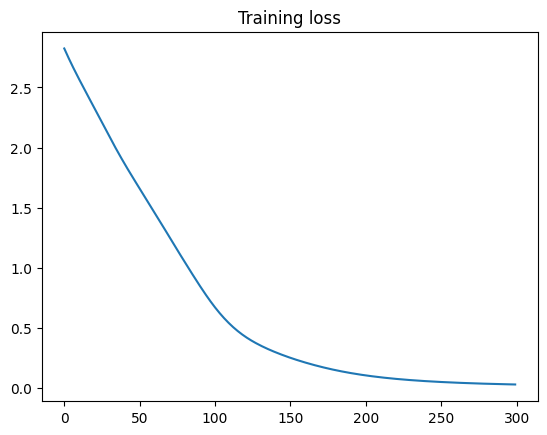

In [17]:
import matplotlib.pylab as plt

# define the neural network architecture
class W2WCBow(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=d, embedding_dim=p)
        self.linear = torch.nn.Linear(in_features=p, out_features=d, bias = False)

    def forward(self, x):
        e = self.embedding(x)
        e = e.mean(axis = 1)
        z = self.linear(e)
        return z
    
# define an instande of the model class
w2w_cbow = W2WCBow()
w2w_cbow(torch.LongTensor(X))

# define an optimizer and loss
optimizer = torch.optim.Adam(lr = 0.015, params = w2w_cbow.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

losses = []
epochs = 300
for epoch in range(epochs):
    w2w_cbow.train()
    scores = w2w_cbow(torch.tensor(X))
    batch_loss = loss_fn(scores, torch.tensor(y))
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    losses.append(batch_loss.detach().numpy())

# visualize the training loss  
plt.plot(losses)
plt.title("Training loss")
plt.show()

What does happen during training? In the beginning word embeddings for context words $\boldsymbol{W}$ and center words $\boldsymbol{V}$ are randomly initialized. Word embeddings of words which are close to each other need to produces high dot product values in order to come along with high probabilities. This is what we want if words are used in the same context (are close to each other in documents). A high dot product results if vectors have very similar elements. Thus, during training parameters for each word vector are updated such that words which are close to each other have similar vectors. In addition, words serve as anchors to recognize similarities between words that do not appear next to each other in documents but are used in similar contexts. One training is finished, it makes sense to use center word vectors $\boldsymbol{V}$ as embeddings for our words. However, one may also experiment and can use context word vectors $\boldsymbol{W}$ or the average vectors of both matrices. Our example is too small to produce high quality embeddings. However if you take a look at the cosine similarity matrix below, you can observe that, e.g., the model learned "sandwich" has a similar meaning to "dog" which makes sense, given our corpus information.

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

word_embeddings = w2w_cbow.linear.weight.detach().numpy() #w2v_cbow.get_layer("center_vectors").get_weights()[0].transpose()
word_embeddings_df = pd.DataFrame(cosine_similarity(word_embeddings), columns = list(word2index.keys()), index = list(word2index.keys()))
word_embeddings_df

,the,dog,would,like,a,piece,of,sandwich,i,to,eat,ice,cream,is,good,friend
the,1.000000,0.970650,-0.921416,0.342322,-0.638373,-0.065339,0.778343,0.996475,0.916812,0.231462,-0.254245,0.997168,0.981551,0.875947,0.946661,0.957215
dog,0.970650,1.000000,-0.907166,0.428567,-0.652956,-0.279145,0.607125,0.986498,0.940176,0.281700,-0.032110,0.965214,0.938424,0.966047,0.949847,0.969105
would,-0.921416,-0.907166,1.000000,-0.663902,0.304134,0.276198,-0.639546,-0.912863,-0.724923,0.137283,0.330066,-0.889587,-0.971188,-0.821615,-0.765422,-0.799669
like,0.342322,0.428567,-0.663902,1.000000,0.369584,-0.753115,-0.079534,0.352068,0.108342,-0.627790,-0.046044,0.273666,0.466611,0.468122,0.124549,0.192920
a,-0.638373,-0.652956,0.304134,0.369584,1.000000,-0.165024,-0.499547,-0.666043,-0.871839,-0.894989,-0.243214,-0.691325,-0.480775,-0.647754,-0.845813,-0.813427
piece,-0.065339,-0.279145,0.276198,-0.753115,-0.165024,1.000000,0.553445,-0.126111,-0.098670,0.184629,-0.621343,-0.022619,-0.090162,-0.476557,-0.048231,-0.108132
of,0.778343,0.607125,-0.639546,-0.079534,-0.499547,0.553445,1.000000,0.729062,0.624237,0.143692,-0.705263,0.791691,0.779561,0.388059,0.691768,0.670043
sandwich,0.996475,0.986498,-0.912863,0.352068,-0.666043,-0.126111,0.729062,1.000000,0.938785,0.273096,-0.172579,0.994606,0.968805,0.912158,0.960984,0.973048
i,0.916812,0.940176,-0.724923,0.108342,-0.871839,-0.098670,0.624237,0.938785,1.000000,0.582789,0.080151,0.937182,0.825633,0.913562,0.995327,0.992925
to,0.231462,0.281700,0.137283,-0.627790,-0.894989,0.184629,0.143692,0.273096,0.582789,1.000000,0.504049,0.298321,0.041643,0.344182,0.528344,0.484454


Note that words in the beginning and end of the sentences are ignored in our example which causes problems for such a small corpus but usually is not problematic for a large corpus. Given a large collection of documents, common embedding dimension $p$ are rather in the hundreds as in comparison to our example.

### SG
The figure below visualizes the CBOW and the SG model. While CBOW uses context words to predict the center word, SG uses the center word to predict context words. Thus, the prediction simplifies to $P \left( w_l | w_i \right)$ for any conext word $w_l \in \lbrace w_{i-t}, w_{i-t+1}, ..., w_{i-1}, w_{i+1}, w_{i + t -1}, w_{i + t}  \rbrace$. As before, we use train two parameter matrices $\boldsymbol{W}, \boldsymbol{V}$, however, this time $\boldsymbol{W}$ represents word embeddings for center words and $\boldsymbol{V}$ word embeddings for context words.

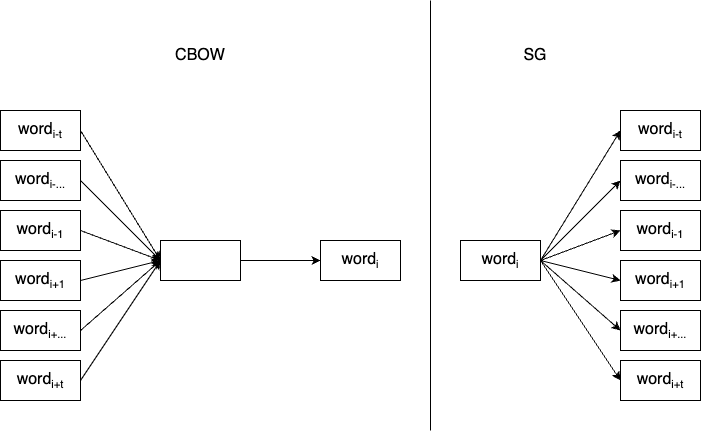

In [19]:
from IPython.display import Image
Image(filename='cbow_sg.png') 

Furthermore, training samples are reduced to one center word and one context word at a time (note this could also be transformed to a multi-label classifiction which should lead to the same or very similar results). Besides these differences, the training process is rather similar. First, we build training samples:

In [20]:
# number of terms in the lexicon
d = len(word2index.keys())
# embedding dimension
p = 3

# context length
k = 2
context_indices = [j for j in range(-k, k+1) if j != 0]

# generate training samples
sample_words = []
samples = []
for doc in corpus:
    for i in range(k, len(doc) - k):
        center_word = doc[i]
        center_word_idx = word2index[doc[i]]
        context_words = [doc[i + idx] for idx in context_indices]
        context_word_idx = [word2index[doc[i + idx]] for idx in context_indices]
        for context, context_word in zip(context_word_idx, context_words):
            sample_words.append((center_word, context_word))
            samples.append((center_word_idx, context))

print("This is how the training samples look like:")
print(sample_words)
print("")
print("This is how the training samples information is provided:")
print(samples)

This is how the training samples look like:
[('would', 'the'), ('would', 'dog'), ('would', 'like'), ('would', 'a'), ('like', 'dog'), ('like', 'would'), ('like', 'a'), ('like', 'piece'), ('a', 'would'), ('a', 'like'), ('a', 'piece'), ('a', 'of'), ('piece', 'like'), ('piece', 'a'), ('piece', 'of'), ('piece', 'the'), ('of', 'a'), ('of', 'piece'), ('of', 'the'), ('of', 'sandwich'), ('to', 'i'), ('to', 'like'), ('to', 'eat'), ('to', 'ice'), ('eat', 'like'), ('eat', 'to'), ('eat', 'ice'), ('eat', 'cream'), ('is', 'a'), ('is', 'dog'), ('is', 'a'), ('is', 'good'), ('a', 'dog'), ('a', 'is'), ('a', 'good'), ('a', 'friend')]

This is how the training samples information is provided:
[(2, 0), (2, 1), (2, 3), (2, 4), (3, 1), (3, 2), (3, 4), (3, 5), (4, 2), (4, 3), (4, 5), (4, 6), (5, 3), (5, 4), (5, 6), (5, 0), (6, 4), (6, 5), (6, 0), (6, 7), (9, 8), (9, 3), (9, 10), (9, 11), (10, 3), (10, 9), (10, 11), (10, 12), (13, 4), (13, 1), (13, 4), (13, 14), (4, 1), (4, 13), (4, 14), (4, 15)]


Next, we prepare the target labels and input features:

In [21]:
# prepare training examples for a neural network
X = [sample[0] for sample in samples]
y = [sample[1] for sample in samples]
#y_one_hot = tf.keras.utils.to_categorical(y, num_classes = d)

print("Input for the neural network:")
print(X)
print("")
print("Target values for the neural network:")
print(y)

Input for the neural network:
[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 9, 9, 9, 9, 10, 10, 10, 10, 13, 13, 13, 13, 4, 4, 4, 4]

Target values for the neural network:
[0, 1, 3, 4, 1, 2, 4, 5, 2, 3, 5, 6, 3, 4, 6, 0, 4, 5, 0, 7, 8, 3, 10, 11, 3, 9, 11, 12, 4, 1, 4, 14, 1, 13, 14, 15]


Define and train the neural network.

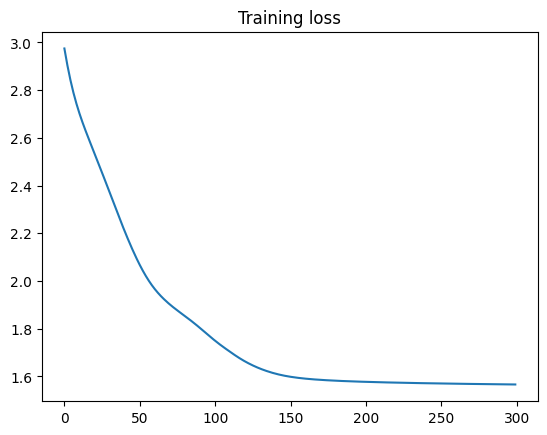

In [22]:
# define the neural network architecture
class W2WSG(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=d, embedding_dim=p)
        self.linear = torch.nn.Linear(in_features=p, out_features=d, bias = False)

    def forward(self, x):
        e = self.embedding(x)
        z = self.linear(e)
        return z
    
# define an instande of the model class
w2w_sg = W2WSG()

# define an optimizer and loss
optimizer = torch.optim.Adam(lr = 0.02, params = w2w_sg.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

losses = []
epochs = 300
for epoch in range(epochs):
    w2w_sg.train()
    scores = w2w_sg(torch.tensor(X))
    batch_loss = loss_fn(scores, torch.tensor(y))
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    losses.append(batch_loss.detach().numpy())

# visualize the training loss  
plt.plot(losses)
plt.title("Training loss")
plt.show()

In [23]:
word_embeddings = w2w_sg.linear.weight.detach().numpy()
word_embeddings_df = pd.DataFrame(cosine_similarity(word_embeddings), columns = list(word2index.keys()), index = list(word2index.keys()))
word_embeddings_df

,the,dog,would,like,a,piece,of,sandwich,i,to,eat,ice,cream,is,good,friend
the,1.000000,-0.004728,-0.410720,-0.165900,0.735380,-0.599328,-0.156866,0.198813,0.425639,-0.527254,0.422726,-0.086234,-0.559244,-0.961414,-0.066353,-0.949136
dog,-0.004728,1.000000,0.745592,-0.195155,0.656198,0.159656,0.071291,-0.559763,-0.898839,-0.793715,-0.896871,-0.995629,-0.821203,0.236553,0.979299,0.210970
would,-0.410720,0.745592,1.000000,-0.587416,0.270328,0.776881,-0.402769,-0.072526,-0.905314,-0.219032,-0.914616,-0.716516,-0.334322,0.645394,0.653596,0.668779
like,-0.165900,-0.195155,-0.587416,1.000000,-0.401097,-0.689979,0.964277,-0.701597,0.221553,-0.043291,0.243550,0.230019,0.165068,-0.028841,0.005500,-0.112737
a,0.735380,0.656198,0.270328,-0.401097,1.000000,-0.215579,-0.221540,-0.097628,-0.297299,-0.866979,-0.301664,-0.723785,-0.940441,-0.531032,0.567144,-0.524908
piece,-0.599328,0.159656,0.776881,-0.689979,-0.215579,1.000000,-0.668215,0.425204,-0.490317,0.424056,-0.506050,-0.121209,0.278370,0.728636,0.041967,0.787824
of,-0.156866,0.071291,-0.402769,0.964277,-0.221540,-0.668215,1.000000,-0.863713,-0.011358,-0.265764,0.011555,-0.035803,-0.061252,0.021550,0.269384,-0.070711
sandwich,0.198813,-0.559763,-0.072526,-0.701597,-0.097628,0.425204,-0.863713,1.000000,0.488805,0.579013,0.468893,0.522361,0.423464,-0.201774,-0.715490,-0.112712
i,0.425639,-0.898839,-0.905314,0.221553,-0.297299,-0.490317,-0.011358,0.488805,1.000000,0.453908,0.999737,0.859149,0.489717,-0.635101,-0.883017,-0.617811
to,-0.527254,-0.793715,-0.219032,-0.043291,-0.866979,0.424056,-0.265764,0.579013,0.453908,1.000000,0.447165,0.832229,0.978198,0.366045,-0.801709,0.406562


### Practical considerations

CBOW aggregates context by summing or averaging context word vectors. This has a smoothing effect which it may be helpful for smaller data sets. On the other side, it does not take full advantage of granular context information. As a consequence, it can be beneficial to use CBOW for smaller corpora and SG for larger ones. The embedding dimension is an important hyperparameter for the model. Choosing higher values may improve the understanding of context similarity, while, at the same time, more data is needed to learn this. Common choices for larger and pre-trained models are in the range $[100, 300]$, however, sometimes embedding sizes go even higher. Another hyperparameter is the window size of the context. Common choices are between $5$ and $10$. Very frequent words can dominate the training of word embeddings. A common technique is to down-sample these words or even completely ignore them. At the same time words which appear very rarely may also be ignored because general relationships are hard to identify.

## Working with word vectors

Once a Word2Vec model has been trained, we can generate numerical representations of words. An important side note is that a corpus usually is preprocessed before the model is trained. One central aspect of preprocessing is tokenization, i.e., the way each text is split into tokens which build the basis for creating a lexicon. Finally, each token in the lexicon will be mapped to a word embedding during the training process. This means, if we use, e.g., lower cases only, the word "Germany" will have no embedding because it is represented by the token "germany" after preprocessing. Consequently, if we process text in a different way than it has been done before training the model, we will receive many unknown token errors when we want to generate word embeddings. If we train our own model, this should be no problem because we can use the same tokenizer for handling text data after model training. However, if we use a pre-trained model and its embeddings, this may become a ciritical issue.

### Common usage

Nevertheless, let us start with a popular pre-trained model and its word embeddings: the [Google News embeddings](https://code.google.com/archive/p/word2vec/). They have been trained using the Google News dataset which includes about 100 billion words. The resulting model comes along with 300 dimensional vectors for 3 million words and phrases. What can we do with these vectors? The following common things come into mind:

* examine word similarities
* examine word analogies
* determine document embeddings
* visualize word 

To determine word similarities, we compute a vector based similarity measure. The most popular choice in the natural language processing domain is the cosine similarity which has been presented in an earlier chapter of this book. For instance, the cell below shows the top ten similar words to the word 

In [24]:
from gensim.models import KeyedVectors

google_word_vectors = KeyedVectors.load_word2vec_format("../language_models/GoogleNews-vectors-negative300.bin.gz", binary = True)
google_word_vectors.most_similar(positive = "crisis")

[('crises', 0.7838959693908691),
 ('turmoil', 0.6912833452224731),
 ('meltdown', 0.6789990067481995),
 ('credit_crunch', 0.6228187084197998),
 ('crisis.The', 0.6024228930473328),
 ('recession', 0.5982968211174011),
 ('downturn', 0.5976395010948181),
 ('subprime_mortgage_crisis', 0.5934383869171143),
 ('economic_downturn', 0.5829673409461975),
 ('liquidity_crunch', 0.5580255389213562)]

We observe cosine similarities in the range between $0.53$ and $0.63$. This brings up the question about the actual range of cosine similarities for all word embeddings. Due to the immense amount of words, we sample 10,000 words from the lexicon and determine their pairwise cosine similarities. The histogram below demonstrates that similarities seem to be roughly in the range $[-0.25, 0.80]$, even though values in the interval $[-1, 1]$ would be possible. This gives us a better understanding of common similarity levels for word pairs are. 

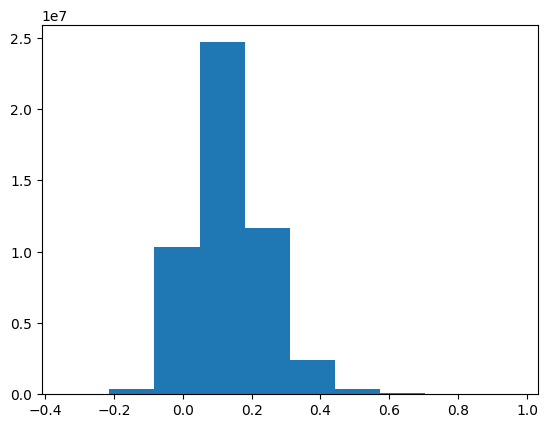

In [25]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pylab as plt
from sklearn.metrics.pairwise import cosine_similarity

# draw 10000 random vectors and determine their pairwise similarities to get an idea about the similarity range
rng = default_rng(seed = 42)
rnd_idx = rng.choice(len(google_word_vectors), size=10000, replace=False)
pairwise_similarities = cosine_similarity(google_word_vectors[rnd_idx]) 
pairwise_similarities_flat = pairwise_similarities[np.tril_indices(pairwise_similarities.shape[0], k = -1)]
plt.hist(pairwise_similarities_flat)
plt.show()

The next impressive aspect of word embeddings is that we can use vector calculus to examine similarities and dissimilarities between words. The most popular example is the word analogy of "woman" to "man" which should be similar to "queen" and "king". Given the vectors $\boldsymbol{w}^{(woman)}, \boldsymbol{w}^{(man)}, \boldsymbol{w}^{(queen)}, \boldsymbol{w}^{(king)}$, we can calculate the differences $\boldsymbol{w}^{(woman)} - \boldsymbol{w}^{(man)}$ and $\boldsymbol{w}^{(queen)} - \boldsymbol{w}^{(king)}$. If the relation of woman to man is similar as the relation of queen to king, we should get:

$$
\boldsymbol{w}^{(woman)} - \boldsymbol{w}^{(man)} \approx \boldsymbol{w}^{(queen)} - \boldsymbol{w}^{(king)} 
$$

thus, 

$$
\boldsymbol{w}^{(woman)} - \boldsymbol{w}^{(man)} + \boldsymbol{w}^{(king)} 
$$

should be most similar to 

$$
\boldsymbol{w}^{(queen)}
$$

Let us find out:

In [26]:
google_word_vectors.similar_by_vector(google_word_vectors["woman"] - google_word_vectors["man"] + google_word_vectors["king"])

[('king', 0.8449392318725586),
 ('queen', 0.7300516366958618),
 ('monarch', 0.6454660296440125),
 ('princess', 0.6156251430511475),
 ('crown_prince', 0.5818676948547363),
 ('prince', 0.5777117609977722),
 ('kings', 0.5613663792610168),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247817993164),
 ('queens', 0.5289887189865112)]

Tadaa! This seems to work pretty good. Note, the calculation can also be done by the most_similar method, positive are the vectors with a positive sign, negative the ones with a negative sign:

In [27]:
google_word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411403656006)]

If we can calculate with words, we can also average and sum word vectors. For instance, we can split a sentence into words and sum or average its word vectors to derive a sentence embedding. 

In [28]:
print("Tokenized sentences:")
print(f"{corpus} \n")
sentence_embeddings = [google_word_vectors.get_mean_vector(sentence) for sentence in corpus]
cosine_similarity_matrix = np.round(cosine_similarity(np.array(sentence_embeddings)), 4)
print("Pairwise cosine similarities:")
pd.DataFrame(cosine_similarity_matrix, index = [f"s{i+1}" for i in range(3)], columns = [f"s{i+1}" for i in range(3)])

Tokenized sentences:
[['the', 'dog', 'would', 'like', 'a', 'piece', 'of', 'the', 'sandwich'], ['i', 'like', 'to', 'eat', 'ice', 'cream'], ['a', 'dog', 'is', 'a', 'good', 'friend']] 

Pairwise cosine similarities:


,s1,s2,s3
s1,1.0000,0.5117,0.5692
s2,0.5117,1.0000,0.3753
s3,0.5692,0.3753,1.0000


Furthermore, we can build topic vectors which are calculated as the average of individual word vectors which represent a similar content. 

In [29]:
topic_words = ["environmental", "social", "governance"]
google_word_vectors.similar_by_vector(google_word_vectors.get_mean_vector(topic_words))

[('social', 0.7614427804946899),
 ('environmental', 0.7357089519500732),
 ('governance', 0.6950607895851135),
 ('ecological', 0.6291204690933228),
 ('corporate_governance_ESG', 0.6060682535171509),
 ('governance_ESG_issues', 0.6004064679145813),
 ('sustainablity', 0.5869180560112),
 ('environmental_sustainability', 0.5842981338500977),
 ('governance_ESG_factors', 0.5816299319267273),
 ('governance_ESG', 0.57416170835495)]

The only thing which is a little unfortunate is that we are not able to visualize how close certain word vectors are to others. This can be overcome by combining dimensionality reduction techniques with word embeddings. Different models can be used for dimensionality reduction. In general, dimensionality reduction tries to find lower dimensional representations of the original word vectors which keep as much of the original behavior as possible. Below, we train the umap reduction model to a sample of 100,000 word vectors. 

In [30]:
import umap
import pickle

try:
    with open("../language_models/w2v_10K/dim_reducer_google.pkl", "rb") as handle:
        dim_reducer = pickle.load(handle)
except:
    print("Train dimensionality reducer first...")
    dim_reducer = umap.UMAP(n_components=2, metric = "cosine")
    rnd_idx = rng.choice(len(google_word_vectors), size=100000, replace=False)
    dim_reducer.fit(google_word_vectors[rnd_idx])
    with open("../language_models/w2v_10K/dim_reducer_google.pkl", 'wb') as handle:
        pickle.dump(dim_reducer, handle, protocol=pickle.HIGHEST_PROTOCOL)

/Users/ralf/Library/Mobile Documents/com~apple~CloudDocs/Kurse/DLTA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Now, we combine these techniques and plot two dimensional representations for similar and random words. In the example below, we look for the $20$ most similar words of the word "crisis". We generate two dimensional representations for the corresponding word vectors by transforming the original $300$ dimensional vectors with the umap dimensionality reduction model. The same thing is done for $100$ randomly selected words. The resulting vectors can be viszalized in the scatter plot below. 

In [31]:
import plotly.express as px

def plot_similar_words_2d(word, n_words, word_vectors, reducer, rnd_state = 42):
    most_sim_words = word_vectors.most_similar(word, topn = n_words)
    positive_words = [element[0] for element in most_sim_words]
    positive_words_2d = reducer.transform(word_vectors[positive_words])
    positive_words_2d_df = pd.DataFrame(positive_words_2d, index = positive_words, columns = ["u1", "u2"])
    positive_words_2d_df.loc[:, "category"] = "positive"

    positive_indices = [word_vectors.key_to_index[positive_word] for positive_word in positive_words]
    negative_indices = [i for i in range(len(word_vectors)) if not(i in positive_indices)]
    np.random.seed(rnd_state)
    negative_words_indices = np.random.choice(negative_indices, 5 * n_words, replace = False).tolist()
    negative_words = [word_vectors.index_to_key[negative_words_index] for negative_words_index in negative_words_indices]
    negative_words_2d = reducer.transform(word_vectors[negative_words_indices])
    negative_words_2d_df = pd.DataFrame(negative_words_2d, index = negative_words, columns = ["u1", "u2"])
    negative_words_2d_df.loc[:, "category"] = "negative"

    words_2d = pd.concat((positive_words_2d_df, negative_words_2d_df))

    fig = px.scatter(words_2d, x = "u1", y = "u2", color = "category", hover_name = words_2d.index, width = 800, height = 600, title = f"Similar and random words for the word: {word} in 2D")
    return fig

fig = plot_similar_words_2d("crisis", 20, google_word_vectors, dim_reducer)
fig.show()

/Users/ralf/Library/Mobile Documents/com~apple~CloudDocs/Kurse/DLTA/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



### Performance evaluation for Word2Vec models

Two popular choices for evaluating the quality of word vectors are predefined analogy tasks as well as similarity tasks. The latter compute the correlation of pairwise word similarities made by humans and the ones derived by word embeddings. See below some examples for these tasks. In addition, another way to examine the quality of word embeddings is to use them for common natural language processing tasks and quantify the outcome. One of the most common sets of tasks is provided by the [General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/). However, if we are interested in domain specific performance, these considerations may not be most important to us. Given we train our word vectors mostly on, e.g., financial documents, it may be not surprising that these word embeddings may lack in their usage for general language understanding. However, they might be better in the representation of domain specific content. 

In [32]:
from gensim.test.utils import datapath

with open(datapath("questions-words.txt"), "r") as file:
    lines = file.readlines()

print("-"*50)
print("Examples for word analogy tasks:")
print("-"*50)

rng = default_rng(seed = 42)
rnd_idx = rng.choice(len(lines), size=5, replace=False)
for i, line in enumerate(lines):
    if i in rnd_idx:
        print(line)

with open(datapath("simlex999.txt"), "r") as file:
    lines = file.readlines()

print("-"*50)
print("Examples for human similarity:")
print("-"*50)
rnd_idx = rng.choice(len(lines), size=5, replace=False)
for i, line in enumerate(lines):
    if i in rnd_idx:
        print(line)

--------------------------------------------------
Examples for word analogy tasks:
--------------------------------------------------
Chisinau Moldova Ljubljana Slovenia

father mother son daughter

he she father mother

smart smartest quick quickest

Korea Korean Netherlands Dutch

--------------------------------------------------
Examples for human similarity:
--------------------------------------------------
unhappy	mad	5.95

whiskey	champagne	5.33

liquor	century	0.4

gun	fur	0.3

attach	join	7.75



### Domain specific word embeddings

If we are in need of domain specific word embeddings, we need to train a model by ourselves. Usually, this comes along with certain shortcomings. First, domain specific corpora usually are smaller which can have a negative impact on embedding quality as the vectors are trained on a lower number of samples. Second, the training of language models can come along with high computational needs. While this usually is no problem for Word2Vec, it certainly is for today's state of the art language models.

For demonstrational purposes, let us compare the embeddings from the Google News corpus with embeddings that I trained. Our model has been trained on a corpus which includes around 115,000 annual 10-K form reports from US stock market companies between the years of 2002 until today. Each of the $49,434$ tokens in our lexicon is represented by a  $256$ dimensional vector.

In [33]:
from gensim.models import KeyedVectors

word_vectors = KeyedVectors.load("../language_models/w2v_10K/w2v_10K.kv")
word_vectors.most_similar(positive = "crisis")

[('turmoil', 0.7795572280883789),
 ('recession', 0.7387425303459167),
 ('crises', 0.7312794327735901),
 ('downturn', 0.6833765506744385),
 ('pandemic', 0.6487988829612732),
 ('covid', 0.6147671341896057),
 ('slowdown', 0.6107375621795654),
 ('unprecedented', 0.6062895059585571),
 ('tightening', 0.6005370616912842),
 ('outbreak', 0.599168062210083)]

Even though the text data spans over a longer history which also includes the subprime mortgage crisis, the word embedding seems to be closely connected to the covid crisis. However, the first words seem to make perfect sense in a more general understanding of a crisis period. 

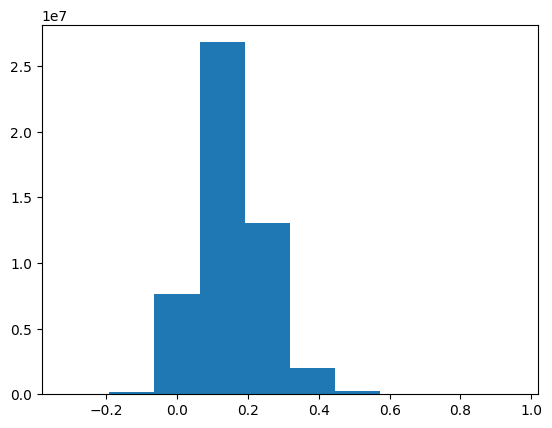

In [34]:
from numpy.random import default_rng
import matplotlib.pylab as plt
from sklearn.metrics.pairwise import cosine_similarity

# draw 10000 random vectors and determine their pairwise similarities to get an idea about the similarity range
rng = default_rng(seed = 42)
rnd_idx = rng.choice(len(word_vectors), size=10000, replace=False)
pairwise_similarities = cosine_similarity(word_vectors[rnd_idx]) 
pairwise_similarities_flat = pairwise_similarities[np.tril_indices(pairwise_similarities.shape[0], k = -1)]
plt.hist(pairwise_similarities_flat)
plt.show()

The range of similarities if very different to the Google News embeddings. This may be impacted by the similar dimensionality of embeddings. 

In [35]:
word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])

[('women', 0.5575689673423767),
 ('babies', 0.5239009261131287),
 ('riding', 0.49364688992500305),
 ('walking', 0.48965153098106384),
 ('female', 0.48954012989997864),
 ('men', 0.48718249797821045),
 ('clothes', 0.48452329635620117),
 ('girls', 0.4834292232990265),
 ('pregnant', 0.48110231757164),
 ('kids', 0.47963348031044006)]

The domain specific vectors fail w.r.t. to this task. This is no big surprise, because it seems very unlikely that royal relationships are often discussed in financial reports. 

In [36]:
print("Tokenized sentences:")
print(f"{corpus} \n")
sentence_embeddings = [word_vectors.get_mean_vector(sentence) for sentence in corpus]
cosine_similarity_matrix = np.round(cosine_similarity(np.array(sentence_embeddings)), 4)
print("Pairwise cosine similarities:")
pd.DataFrame(cosine_similarity_matrix, index = [f"s{i+1}" for i in range(3)], columns = [f"s{i+1}" for i in range(3)])

Tokenized sentences:
[['the', 'dog', 'would', 'like', 'a', 'piece', 'of', 'the', 'sandwich'], ['i', 'like', 'to', 'eat', 'ice', 'cream'], ['a', 'dog', 'is', 'a', 'good', 'friend']] 

Pairwise cosine similarities:


,s1,s2,s3
s1,1.0000,0.7398,0.7805
s2,0.7398,1.0000,0.5976
s3,0.7805,0.5976,1.0000


Nevertheless, as before the sentence embedding similarities seem to make sense. However, the distinction with Google News embeddings seems to be better. 

In [37]:
topic_words = ["environmental", "social", "governance"]
word_vectors.similar_by_vector(word_vectors.get_mean_vector(topic_words))

[('governance', 0.7420051097869873),
 ('environmental', 0.7306384444236755),
 ('social', 0.729841411113739),
 ('esg', 0.5995034575462341),
 ('sustainability', 0.5876127481460571),
 ('workplace', 0.5621027946472168),
 ('cybersecurity', 0.5460812449455261),
 ('worker', 0.5370159149169922),
 ('health', 0.510663628578186),
 ('stewardship', 0.5101289749145508)]

Similar words to the environmental, social and governance topic make perfect sense. 

In [38]:
import umap
import pickle

try:
    with open("../language_models/w2v_10K/dim_reducer_10K.pkl", "rb") as handle:
        dim_reducer = pickle.load(handle)
except:
    print("Train dimensionality reducer first...")
    dim_reducer = umap.UMAP(n_components=2, metric = "cosine")
    dim_reducer.fit(word_vectors.get_normed_vectors())
    with open("../language_models/w2v_10K/dim_reducer_10K.pkl", 'wb') as handle:
        pickle.dump(dim_reducer, handle, protocol=pickle.HIGHEST_PROTOCOL)

fig = plot_similar_words_2d("crisis", 20, word_vectors, dim_reducer)
fig.show()

/Users/ralf/Library/Mobile Documents/com~apple~CloudDocs/Kurse/DLTA/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



This can also be a coinsidence, however, the similar words are closer to each other than in comparison to the Google News model. 

## Outlook 

In this chapter, we learned how meaningful word representations can be trained. For many applications, we are in need of meaningful representations for full documents or at least parts of them. For instance, a numerical representation of a financial news headline may be used to analyze stock market reactions to financial news. We have seen in this chapter that such representation can be derived by summing or averaging numerical representations for each word in a document. However, this approach may be not granular enough, especially for longer documents with different contents. Furthermore, it gives identical weights to each part of the document. Both shortcomings are tackled by other approaches. The first is how to derive more granular embeddings for documents and will be discussed in the next section. Afterwards, we head towards the self-attention mechanism of modern language models which deals among others with the challenge to focus on the important parts of documents.